In [5]:
import urllib.request
import tarfile
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

/Users/renujakkampudi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# Define dataset URL and target path
dataset_url = "http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz"
dataset_path = "/Users/renujakkampudi/Desktop/ASU/Spring 2025/Statistical Machine Learning/speech_commands_v0.01.tar.gz"
extract_path = "/Users/renujakkampudi/Desktop/ASU/Spring 2025/Statistical Machine Learning/speech_commands"

# Download the dataset
print("Downloading dataset...")
urllib.request.urlretrieve(dataset_url, dataset_path)

# Extract the dataset
print("Extracting dataset...")
with tarfile.open(dataset_path, "r:gz") as tar:
    tar.extractall(extract_path)

print("Dataset successfully downloaded and extracted!")

Extracting dataset...
Dataset successfully downloaded and extracted!


In [ ]:
data_path = extract_path

# Step 1: Count total audio files and display class distribution
file_counts = {}
for root, dirs, files in os.walk(data_path):
    label = os.path.basename(root)
    if label and label != "_background_noise_":
        file_counts[label] = len([f for f in files if f.endswith('.wav')])
total_files = sum(file_counts.values())
print(f"Total audio files: {total_files}")
print("Class distribution:")
for label, count in file_counts.items():
    print(f"{label}: {count} files")

Total audio files: 64721
Class distribution:
speech_commands: 0 files
right: 2367 files
eight: 2352 files
cat: 1733 files
tree: 1733 files
bed: 1713 files
happy: 1742 files
go: 2372 files
dog: 1746 files
no: 2375 files
wow: 1745 files
nine: 2364 files
left: 2353 files
stop: 2380 files
three: 2356 files
sheila: 1734 files
one: 2370 files
bird: 1731 files
zero: 2376 files
seven: 2377 files
up: 2375 files
marvin: 1746 files
two: 2373 files
house: 1750 files
down: 2359 files
six: 2369 files
yes: 2377 files
on: 2367 files
five: 2357 files
off: 2357 files
four: 2372 files


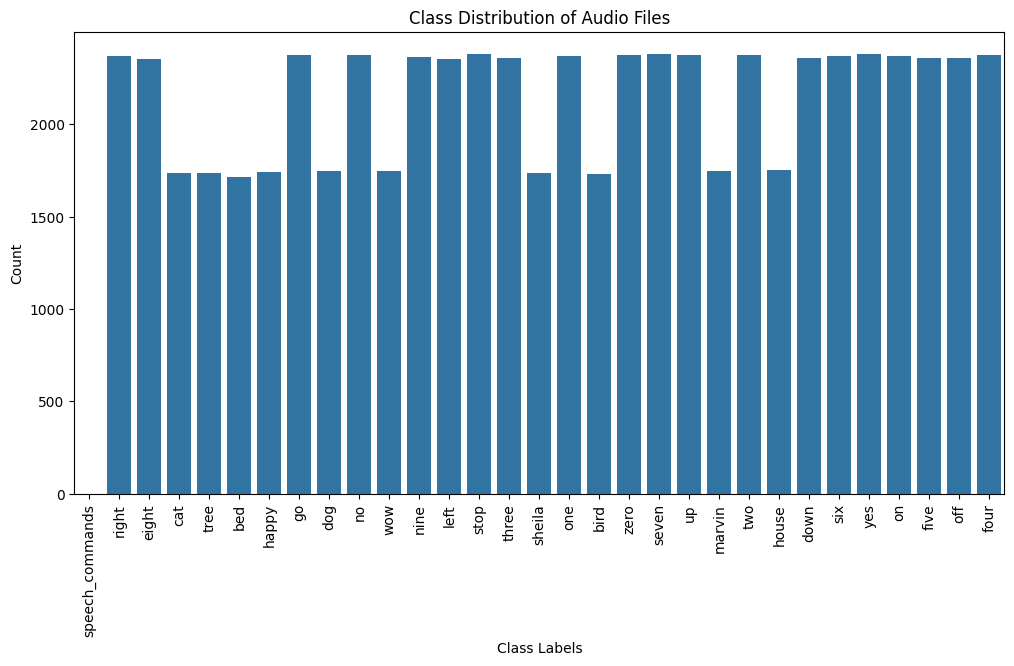

In [8]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(file_counts.keys()), y=list(file_counts.values()))
plt.title('Class Distribution of Audio Files')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

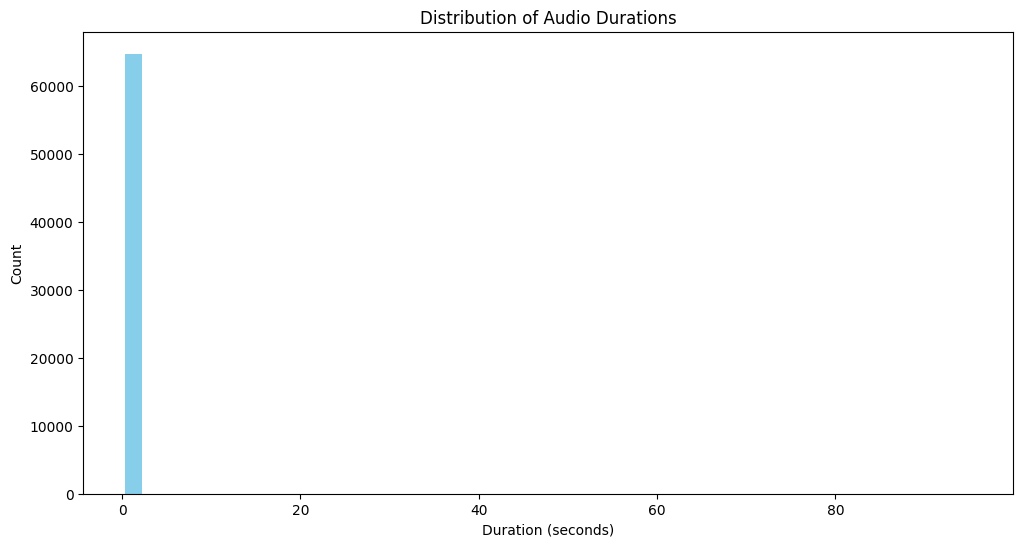

Min duration: 0.3716 seconds
Max duration: 95.1831 seconds
Mean duration: 0.9907 seconds
Median duration: 1.0000 seconds
Plotting waveform and spectrogram for: /Users/renujakkampudi/Desktop/ASU/Spring 2025/Statistical Machine Learning/speech_commands/right/988e2f9a_nohash_0.wav


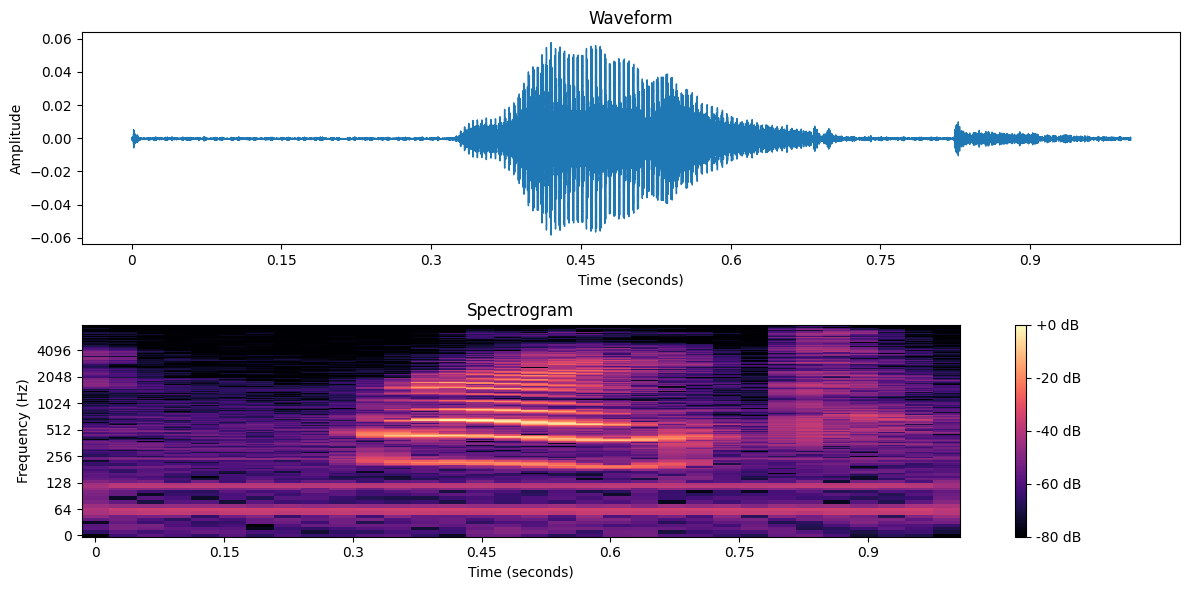

In [9]:
# Step 2: Analyze audio durations
durations = []
wav_files = []
for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            wav_files.append(file_path)
            audio, sr = librosa.load(file_path, sr=None)
            durations.append(len(audio) / sr)

# Plot audio duration distribution
plt.figure(figsize=(12, 6))
plt.hist(durations, bins=50, color='skyblue')
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

print(f"Min duration: {min(durations):.4f} seconds")
print(f"Max duration: {max(durations):.4f} seconds")
print(f"Mean duration: {np.mean(durations):.4f} seconds")
print(f"Median duration: {np.median(durations):.4f} seconds")
# Step 3: Visualize audio waveforms and spectrograms
def plot_waveform_and_spectrogram(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(12, 6))

    # Plot waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    # Plot spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()
# Plot for a sample audio file
sample_file = wav_files[0]
print(f"Plotting waveform and spectrogram for: {sample_file}")
plot_waveform_and_spectrogram(sample_file)

In [10]:

# Step 3: Extract MFCC features
def extract_mfcc_features(file_path, n_mfcc=13, include_deltas=True):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    if include_deltas:
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs])
    else:
        features = mfccs

    return features.T  # Transpose to [time, features]

In [11]:
# Prepare data and labels
files, labels = [], []
for root, dirs, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith('.wav'):
            label = os.path.basename(root)
            if label != '_background_noise_':
                files.append(os.path.join(root, filename))
                labels.append(label)


In [14]:
from tqdm.auto import tqdm
# Encode labels and create mappings
unique_labels = sorted(set(labels))
label_to_index = {label: i for i, label in enumerate(unique_labels)}
y_indices = np.array([label_to_index[label] for label in labels])

# Extract MFCC features
X_features = []
for file in tqdm(files, desc='Extracting MFCC Features'):
    mfcc_features = extract_mfcc_features(file)
    X_features.append(mfcc_features)

# Pad or truncate to make all sequences the same length
max_len = max(len(x) for x in X_features)
X_features_padded = np.array([np.pad(x, ((0, max_len - len(x)), (0, 0)), mode='constant') for x in X_features])

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X_features_padded, y_indices, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode labels
y_train_onehot = to_categorical(y_train, len(unique_labels))
y_val_onehot = to_categorical(y_val, len(unique_labels))
y_test_onehot = to_categorical(y_test, len(unique_labels))

/Users/renujakkampudi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



























































































































































































































































































































































































































































































































































































































































































































































In [15]:
# Step 4: Define GRU/LSTM model
def build_lstm_gru_model(input_shape, num_classes, use_gru=True):
    model = Sequential()
    if use_gru:
        model.add(GRU(128, return_sequences=False, input_shape=input_shape))
    else:
        model.add(LSTM(128, return_sequences=False, input_shape=input_shape))
    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# Build and train GRU model
input_shape = X_train.shape[1:]
num_classes = len(unique_labels)
model = build_lstm_gru_model(input_shape, num_classes, use_gru=True)

from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs without improvement
    restore_best_weights=True
)

# Model training with early stopping
history = model.fit(
    X_train, y_train_onehot,
    epochs=50, batch_size=32,
    validation_data=(X_val, y_val_onehot),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0571 - loss: 3.3878 - val_accuracy: 0.3662 - val_loss: 2.2177
Epoch 2/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2538 - loss: 2.3789 - val_accuracy: 0.5692 - val_loss: 1.4597
Epoch 3/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4034 - loss: 1.8675 - val_accuracy: 0.6645 - val_loss: 1.1645
Epoch 4/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4920 - loss: 1.6075 - val_accuracy: 0.7242 - val_loss: 0.9637
Epoch 5/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5563 - loss: 1.4253 - val_accuracy: 0.7533 - val_loss: 0.8419
Epoch 6/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5962 - loss: 1.3135 - val_accuracy: 0.7772 - val_loss: 0.7722
Epoch 7/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6133 - loss: 1.2467 - val_accuracy: 0.7916 - val_loss: 0.7273
Epoch 8/50
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6269 - loss: 1.203

In [19]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_acc:.4f}")

304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8553 - loss: 0.4834
Test Accuracy: 0.8518


304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

         bed       0.81      0.85      0.83       282
        bird       0.85      0.79      0.82       264
         cat       0.87      0.88      0.88       276
         dog       0.81      0.81      0.81       249
        down       0.82      0.75      0.78       349
       eight       0.90      0.91      0.91       387
        five       0.88      0.74      0.81       360
        four       0.91      0.88      0.89       339
          go       0.65      0.71      0.68       346
       happy       0.92      0.91      0.92       243
       house       0.97      0.90      0.93       258
        left       0.87      0.83      0.85       327
      marvin       0.80      0.83      0.81       275
        nine       0.91      0.81      0.86       335
          no       0.77      0.85      0.81       321
         off       0.83      0.83      0.83       340
          on    

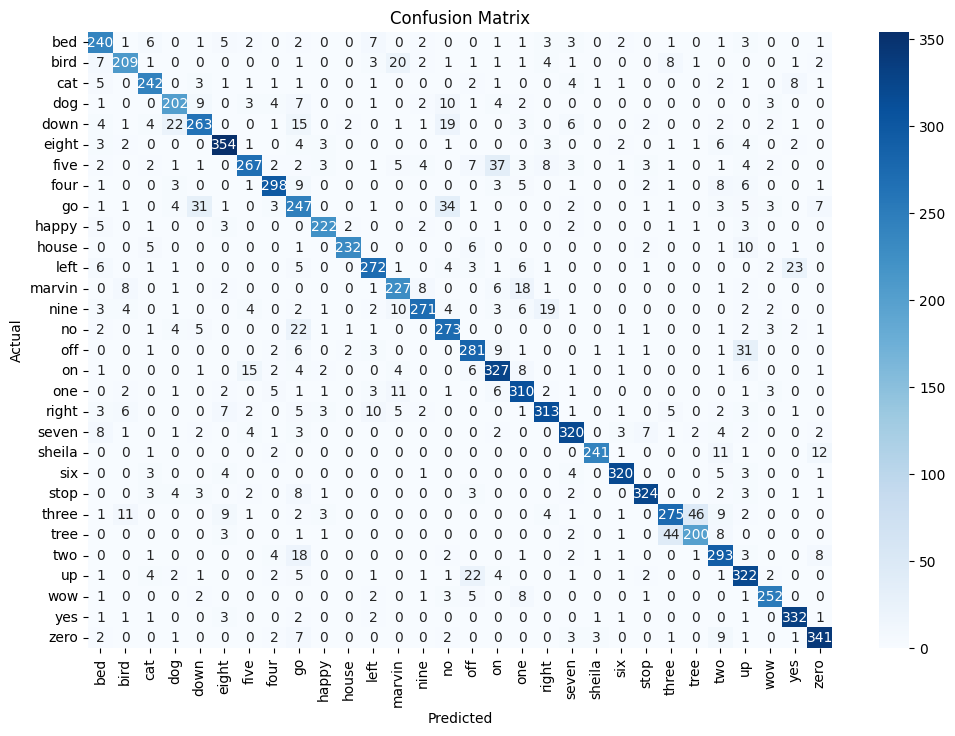

In [18]:
# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=unique_labels))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()